# TensorFlow test code for Siamese nets with mnist data

In [5]:
# Package imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import math
import pdb

# Functions / Defs

In [6]:
#Functions for downloading and reading MNIST data.
from __future__ import print_function
import gzip
import os
import urllib
import numpy

SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
def maybe_download(filename, work_directory):
    """Download the data from Yann's website, unless it's already here."""
    if not os.path.exists(work_directory):
        os.mkdir(work_directory)
    filepath = os.path.join(work_directory, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.urlretrieve(SOURCE_URL + filename, filepath)
        
    statinfo = os.stat(filepath)
    print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
    return filepath

def _read32(bytestream):
    dt = numpy.dtype(numpy.uint32).newbyteorder('>')
    return numpy.frombuffer(bytestream.read(4), dtype=dt)

def extract_images(filename):
    """Extract the images into a 4D uint8 numpy array [index, y, x, depth]."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' %(magic, filename))
        num_images = _read32(bytestream)
        rows = _read32(bytestream)
        cols = _read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        data = numpy.frombuffer(buf, dtype=numpy.uint8)
        data = data.reshape(num_images, rows, cols, 1)
        return data

def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = numpy.arange(num_labels) * num_classes
    labels_one_hot = numpy.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

def extract_labels(filename, one_hot=False):
    """Extract the labels into a 1D uint8 numpy array [index]."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2049:
            raise ValueError('Invalid magic number %d in MNIST label file: %s' %(magic, filename))
        num_items = _read32(bytestream)
        buf = bytestream.read(num_items)
        labels = numpy.frombuffer(buf, dtype=numpy.uint8)
        if one_hot:
            return dense_to_one_hot(labels)
    
        return labels

class DataSet(object):
    def __init__(self, images, labels, fake_data=False):
        if fake_data:
            self._num_examples = 10000
        else:
            assert images.shape[0] == labels.shape[0], ("images.shape: %s labels.shape: %s" % (images.shape,labels.shape))
        self._num_examples = images.shape[0]
        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, rows*columns] (assuming depth == 1)
        assert images.shape[3] == 1
        images = images.reshape(images.shape[0],
                              images.shape[1] * images.shape[2])
        # Convert from [0, 255] -> [0.0, 1.0].
        images = images.astype(numpy.float32)
        images = numpy.multiply(images, 1.0 / 255.0)
        self._images = images
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0
        @property
        def images(self):
            return self._images
        @property
        def labels(self):
            return self._labels
        @property
        def num_examples(self):
            return self._num_examples
        @property
        def epochs_completed(self):
            return self._epochs_completed
        def next_batch(self, batch_size, fake_data=False):
            """Return the next `batch_size` examples from this data set."""
            if fake_data:
                fake_image = [1.0 for _ in xrange(784)]
                fake_label = 0
                return [fake_image for _ in xrange(batch_size)], [fake_label for _ in xrange(batch_size)]
        
            start = self._index_in_epoch
            self._index_in_epoch += batch_size
            if self._index_in_epoch > self._num_examples:
                # Finished epoch
                self._epochs_completed += 1
                # Shuffle the data
                perm = numpy.arange(self._num_examples)
                numpy.random.shuffle(perm)
                self._images = self._images[perm]
                self._labels = self._labels[perm]
                # Start next epoch
                start = 0
                self._index_in_epoch = batch_size
                assert batch_size <= self._num_examples
                
            end = self._index_in_epoch
            return self._images[start:end], self._labels[start:end]


def read_data_sets(train_dir, fake_data=False, one_hot=False):
    class DataSets(object):
        pass
    data_sets = DataSets()
    if fake_data:
        data_sets.train = DataSet([], [], fake_data=True)
        data_sets.validation = DataSet([], [], fake_data=True)
        data_sets.test = DataSet([], [], fake_data=True)
        return data_sets
    
    TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
    TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
    TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
    TEST_LABELS = 't10k-labels-idx1-ubyte.gz'
    VALIDATION_SIZE = 5000
    local_file = maybe_download(TRAIN_IMAGES, train_dir)
    train_images = extract_images(local_file)
    local_file = maybe_download(TRAIN_LABELS, train_dir)
    train_labels = extract_labels(local_file, one_hot=one_hot)
    local_file = maybe_download(TEST_IMAGES, train_dir)
    test_images = extract_images(local_file)
    local_file = maybe_download(TEST_LABELS, train_dir)
    test_labels = extract_labels(local_file, one_hot=one_hot)
    #validation_images = train_images[:VALIDATION_SIZE]
    #validation_labels = train_labels[:VALIDATION_SIZE]
    #train_images = train_images[VALIDATION_SIZE:]
    #train_labels = train_labels[VALIDATION_SIZE:]
    data_sets.train = DataSet(train_images, train_labels)
    #data_sets.validation = DataSet(validation_images, validation_labels)
    data_sets.test = DataSet(test_images, test_labels)
    return data_sets

In [17]:
# Model Architecture Defs

def build_model(X_,_dropout,node_sizes,net_type):
    if net_type == 'mlpnet':
        model = mlpnet(X_,_dropout,node_sizes)
    elif net_type == 'convnet':
        model = convnet(X_,_dropout,node_sizes)
    else: 
        print('unknown net architecture type')
    return model

#MLP
def mlpnet(image,_dropout,node_sizes):
    l1 = mlp(image,node_sizes['input'],node_sizes['l1'],name='l1')
    l1 = tf.nn.dropout(l1,_dropout)
    l2 = mlp(l1,node_sizes['l1'],node_sizes['l2'],name='l2')
    l2 = tf.nn.dropout(l2,1)
    l3 = mlp(l2,node_sizes['l2'],node_sizes['output'],name='l3')
    return l3

def mlp(input_,input_dim,output_dim,name="mlp"):
    with tf.variable_scope(name):
        w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.random_normal_initializer(mean = 0.001,stddev=0.02))
        return tf.nn.relu(tf.matmul(input_,w))

#Convnet
def convnet(X_,_dropout,node_sizes):
    image_dim = int(np.sqrt(node_sizes['input']))
    final_image_vector_size = node_sizes['input']/node_sizes['max_pool_redux_factor']
    
    X_image = tf.reshape(X_, [-1,image_dim,image_dim,1])
    l1 = conv(X_image,node_sizes['kernel_dim'], 1, node_sizes['l1'], name='l1')  
    l1 = tf.nn.dropout(l1,_dropout)
    l2 = conv(l1,node_sizes['kernel_dim'], node_sizes['l1'], node_sizes['l2'], name='l2')
    l2 = tf.nn.dropout(l2,_dropout)
    
    #reshape to vector (reduced image size*number of filters)
    l2_flat = tf.reshape(l2, [-1, final_image_vector_size*node_sizes['l2']])    
    l3 = mlp(l2_flat,final_image_vector_size*node_sizes['l2'],node_sizes['output'],name='mlp')    
    #l3 = tf.nn.dropout(l3,_dropout) #Doesnt work well
    return l3
    
def conv(input_, kernel_dim, in_channels, output_dim,name="conv"):
    with tf.variable_scope(name):
        W = tf.get_variable('w',[kernel_dim, kernel_dim, in_channels, output_dim],tf.float32,tf.random_normal_initializer(mean = 0.001,
                                                                                                     stddev=0.02))
        b = tf.get_variable('b',[output_dim],tf.float32,tf.constant_initializer(0.1))                        
        h_conv = tf.nn.relu(conv2d(input_, W) + b)
        h_pool = max_pool_2x2(h_conv)
        return h_pool
    
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        

# Other helper functions
def next_batch(s,e,inputs,labels):
    input1 = inputs[s:e,0]
    input2 = inputs[s:e,1]        
    y = np.reshape(labels[s:e],(len(range(s,e)),1))    
    return input1,input2,y

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    left_digits = []
    right_digits = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]            
            left_digits.append(d)
            right_digits.append(d)            
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            left_digits.append(d)
            right_digits.append(dn)
    return np.array(pairs), np.array(labels), np.array(left_digits), np.array(right_digits)


# Loss & Accuracy computation
    - This needs to be modified for customized loss / distance computations

In [8]:
# Loss and accuracy
def contrastive_loss(y,d):
    tmp= y *tf.square(d)
    #tmp= tf.mul(y,tf.square(d))
    tmp2 = (1-y) *tf.square(tf.maximum((1 - d),0))
    return tf.reduce_sum(tmp +tmp2)/batch_size/2

def compute_accuracy(prediction,labels):
    return labels[prediction.ravel() < 0.5].mean()
    #return tf.reduce_mean(labels[prediction.ravel() < 0.5])


# Download the data, create paired sets, plot sample input

In [9]:
mnist = read_data_sets("/tmp/data",one_hot=False)

Succesfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Succesfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Succesfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Succesfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


/mnt/tigrlab/projects/nikhil/ADNI_prediction/code/conda_envs/tensorflow_gpu/lib/python2.7/site-packages/ipykernel/__main__.py:37: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [10]:
# Initializing the variables and create train-test sets
init = tf.initialize_all_variables()

# the data, shuffled and split between train and test sets
X_train = mnist.train._images
y_train = mnist.train._labels
X_test = mnist.test._images
y_test = mnist.test._labels

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

global_step = tf.Variable(0,trainable=False)
starter_learning_rate = 0.0001
learning_rate = tf.train.exponential_decay(starter_learning_rate,global_step,10,0.1,staircase=True)

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(10)]
tr_pairs, tr_y, left_digits, right_digits = create_pairs(X_train, digit_indices)
digit_indices = [np.where(y_test == i)[0] for i in range(10)]
te_pairs, te_y, left_digits, right_digits = create_pairs(X_test, digit_indices)

print(len(left_digits), len(right_digits))
#tr_pairs = np.reshape(tr_pairs,(108400,2,28,28))
#te_pairs = np.reshape(te_pairs,(17820,2,28,28))

print(tr_pairs.shape)

(60000, 784) (60000,) (10000, 784) (10000,)
17820 17820
(108400, 2, 784)


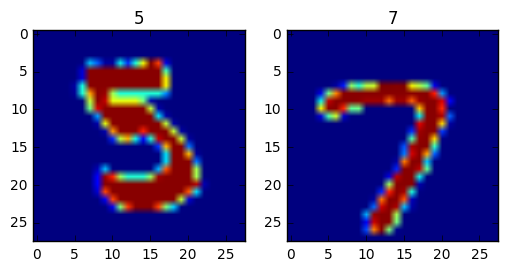

In [11]:
# Plot sample input images 
te_pairs_img = np.reshape(te_pairs,(17820,2,28,28))
i=10001
plt.subplot(1,2,1)
plt.imshow(te_pairs_img[i,0,:,:])
plt.title(left_digits[i])
plt.subplot(1,2,2)
plt.imshow(te_pairs_img[i,1,:,:])
plt.title(right_digits[i])

# Define input and model tensors + optimizer & run the session

In [22]:
batch_size = 128
node_sizes = {'input':784,'l1':32,'l2':32,'output':2,'kernel_dim':5,'max_pool_redux_factor':16}

with tf.Graph().as_default():    
    #Placeholders
    images_L = tf.placeholder(tf.float32,shape=([None,node_sizes['input']]),name='L')
    images_R = tf.placeholder(tf.float32,shape=([None,node_sizes['input']]),name='R')
    labels = tf.placeholder(tf.float32,shape=([None,1]),name='gt')
    dropout_f = tf.placeholder("float")

    #Left and Right branches
    with tf.variable_scope("siamese") as scope:
        model1= build_model(images_L,dropout_f,node_sizes,'convnet')
        scope.reuse_variables()
        model2 = build_model(images_R,dropout_f,node_sizes,'convnet')

    #Distane and contrastice loss
    distance  = tf.sqrt(tf.reduce_sum(tf.pow(tf.sub(model1,model2),2),1,keep_dims=True))
    loss = contrastive_loss(labels,distance)
    
    t_vars = tf.trainable_variables()
    d_vars  = [var for var in t_vars if 'l' in var.name]
    batch = tf.Variable(0)
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    #optimizer = tf.train.RMSPropOptimizer(0.0001,momentum=0.9,epsilon=1e-6).minimize(loss)

    # Launch the graph
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        #sess.run(init)
        tf.initialize_all_variables().run()
        # Training cycle
        for epoch in range(10):
            avg_loss = 0.
            avg_acc = 0.
            total_batch = int(tr_pairs.shape[0]/batch_size)
            start_time = time.time()
            # Loop over all batches
            for i in range(total_batch):
                s  = i * batch_size
                e = (i+1) *batch_size
                # Fit training using batch data
                input1,input2,y = next_batch(s,e,tr_pairs,tr_y)           

                #print(input1.shape, input2.shape, y.shape)                
                _,loss_value,predict=sess.run([optimizer,loss,distance], 
                                              feed_dict={images_L:input1,images_R:input2,labels:y,dropout_f:0.5})

                feature1=model1.eval(feed_dict={images_L:input1,dropout_f:.50})
                feature2=model2.eval(feed_dict={images_R:input2,dropout_f:.50})

                tr_acc = compute_accuracy(predict,y)
                #print(tr_acc)
                if math.isnan(tr_acc) and epoch != 0:
                    print('tr_acc %0.2f' % tr_acc)
                    pdb.set_trace()

                avg_loss += loss_value
                avg_acc +=tr_acc*100
            #print('epoch %d loss %0.2f' %(epoch,avg_loss/total_batch))
            duration = time.time() - start_time
            print('epoch %d  time: %f loss %0.5f acc %0.2f' %(epoch,duration,avg_loss/(total_batch),avg_acc/total_batch))


#         y = np.reshape(tr_y,(tr_y.shape[0],1))
#         predict=distance.eval(feed_dict={images_L:tr_pairs[:,0],images_R:tr_pairs[:,1],labels:y,dropout_f:1.0})
#         tr_acc = compute_accuracy(predict,y)
#         print('Accuract training set %0.2f' % (100 * tr_acc))


        # Test model        
        test_feature_1 = model1.eval(feed_dict={images_L:te_pairs[:,0],dropout_f:1})
        test_feature_2 = model2.eval(feed_dict={images_R:te_pairs[:,1],dropout_f:1})
        predict=distance.eval(feed_dict={images_L:te_pairs[:,0],images_R:te_pairs[:,1],labels:y,dropout_f:1.0})
        y = np.reshape(te_y,(te_y.shape[0],1))
        te_acc = compute_accuracy(predict,y)
        print('Accuract test set %0.2f' % (100 * te_acc))

epoch 0  time: 14.263399 loss 0.07190 acc 78.15
epoch 1  time: 14.207814 loss 0.04876 acc 86.30
epoch 2  time: 14.282701 loss 0.04304 acc 88.35
epoch 3  time: 14.325263 loss 0.04025 acc 89.23
epoch 4  time: 14.269977 loss 0.03943 acc 89.56
epoch 5  time: 14.265203 loss 0.03792 acc 90.09
epoch 6  time: 14.284362 loss 0.03788 acc 90.06
epoch 7  time: 14.266493 loss 0.03772 acc 90.33
epoch 8  time: 14.261866 loss 0.03657 acc 90.72
epoch 9  time: 14.299771 loss 0.03653 acc 90.71
Accuract test set 86.55


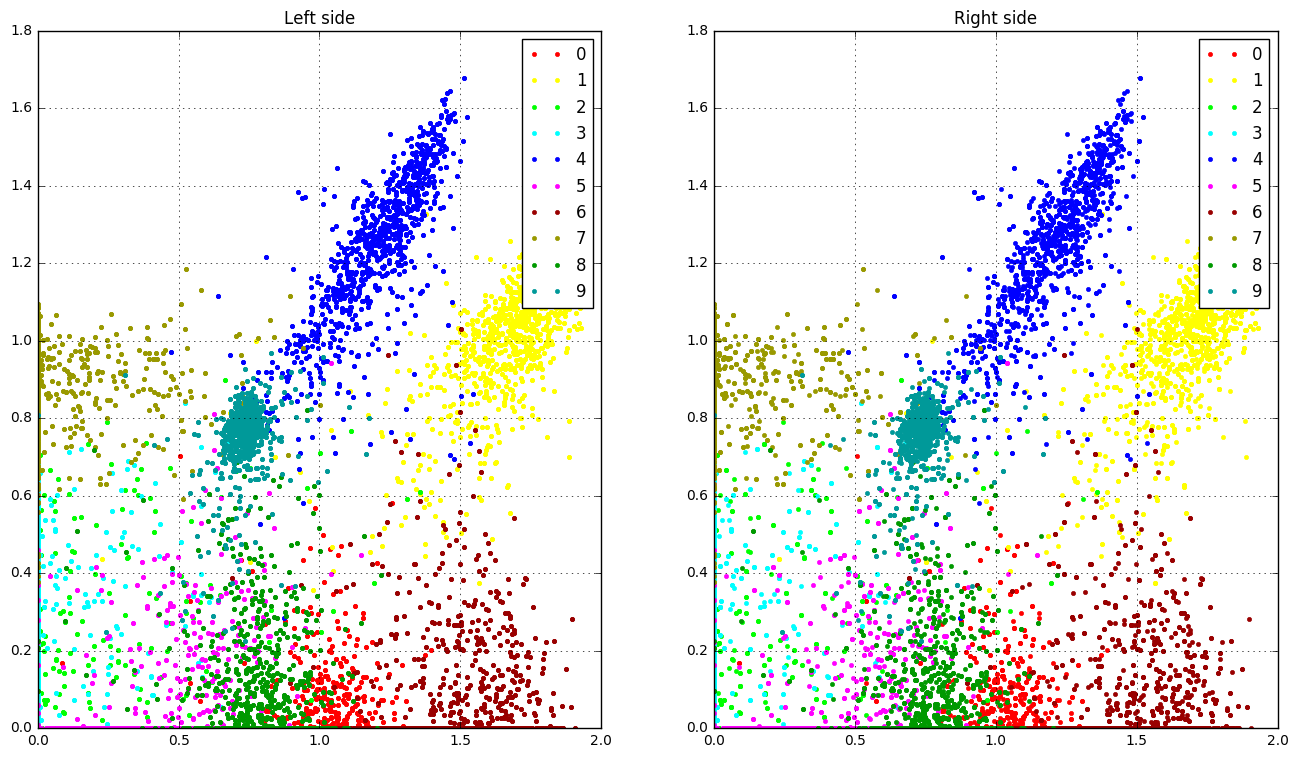

In [25]:
#Plot embeddings
f = plt.figure(figsize=(16,9))
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', 
     '#ff00ff', '#990000', '#999900', '#009900', '#009999']

plt.subplot(1,2,1)
x = test_feature_1[:,0] 
y = test_feature_1[:,1] 
labels = left_digits
for i in range(10):
    plt.plot(x[labels==i],y[labels==i],'.', c=c[i])

plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.grid()
plt.title('Left side')

plt.subplot(1,2,2)
x = test_feature_2[:,0] 
y = test_feature_2[:,1] 
labels = right_digits
for i in range(10):
    plt.plot(x[labels==i],y[labels==i],'.', c=c[i])

plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.grid()
plt.title('Right side')